In [32]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))


import os
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns; 
from tqdm import tqdm
from pathlib import Path
import json
from skbio.stats.distance import permanova, DistanceMatrix
from skbio import DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix
from skbio.stats.distance import permanova
import random
from PIL import Image
from scipy import stats
# from scipy.optimize import curve_fit
# from tqdm import tqdm
# import scipy
# import pickle 
# import math
# from scipy.spatial import KDTree





dark_pink = '#BE575F'
dark_blue = '#232C56'

# Get the current working directory
current_working_dir = os.getcwd()
current_working_dir = '//'.join(current_working_dir.split('\\')[0:-2]) + r'//data/f5//'


In [2]:
def parse_training_levels(training_levels):
    t_levels = []
    for row in training_levels:
        row = row.replace('nan', 'None')
        row = '[' + ', '.join(convert_float_string(x) for x in row.strip('[]').split(', ')) + ']'
        t_levels.append(literal_eval(row))
    return t_levels

def calculate_mean_std(t_levels, mask):
    trial_scores = conactinate_nth_items(np.array(t_levels)[mask])
    mean_curve = [np.mean(item) for item in trial_scores]
    std_curve = [np.std(item) for item in trial_scores]
    return mean_curve, std_curve

def fill_between_mean_std(ax, mean_curve, std_curve, color):
    upper = np.array(mean_curve[:xlim]) + np.array(std_curve[:xlim])
    lower = np.array(mean_curve[:xlim]) - np.array(std_curve[:xlim])
    upper[upper > 50] = 50  # Ceiling effect cutoff
    ax.fill_between(range(len(upper)), lower, upper, alpha=0.2, edgecolor='None', facecolor=color, linewidth=1, linestyle='dashdot', antialiased=True)
    
def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def convert_float_string(s):
    try:
        # Attempt to convert scientific notation to a plain float string
        if 'e' in s.lower():
            value = float(s)
            return str(value)
        else:
            return s  # Return original string if not in scientific notation
    except ValueError:
        return s  # Return original string if not a valid float

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth


def extend_line(point1, point2, extend_direction):
    # Calculate the slope of the line
    slope = (point2[1] - point1[1]) / (point2[0] - point1[0])

    # Calculate the new coordinates
    if extend_direction == "positive":
        new_x = point2[0] + 0.4 * (point2[0] - point1[0])
        new_y = point2[1] + 0.4 * (point2[1] - point1[1])
    elif extend_direction == "negative":
        new_x = point1[0] - 0.3 * (point2[0] - point1[0])
        new_y = point1[1] - 0.3 * (point2[1] - point1[1])
    else:
        raise ValueError("Invalid extend direction. Must be 'positive' or 'negative'.")

    return [(point1[0], point1[1]), (point2[0], point2[1]), (new_x, new_y)]


def bin_position_data(x, y, n_bins):
   # Create bins for y values
    bin_edges = np.linspace(0, 1, n_bins)
    
    # Calculate bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Assign each data point to the closest bin
    bin_indices = np.argmin(np.abs(np.subtract.outer(y, bin_centers)), axis=1)
    
    # Initialize arrays to store binned data
    binned_x = [[] for _ in range(n_bins)]
    
    # Populate binned arrays
    for i in range(len(y)):
        bin_idx = bin_indices[i]
        binned_x[bin_idx].append(x[i])
    
    # Calculate mean and SEM for each bin
    bin_means = np.array([np.mean(b) for b in binned_x])
    bin_sems = np.array([np.std(b) for b in binned_x])
    
    return bin_means, bin_sems,bin_edges,binned_x

def plot_coactive_props(ax,ax2,e_coactive_freqs_counts,color):
    means = []
    stds = []
    x_ = []
    for item in e_coactive_freqs_counts:
        ax.plot(np.ones(len(e_coactive_freqs_counts['1']))*(1),e_coactive_freqs_counts['1'],'o', c = color, alpha = 0.5, markeredgewidth = 0, markersize = 9)
        x_ += [item]
        means += [np.median(e_coactive_freqs_counts['1'])]
        stds += [np.std(e_coactive_freqs_counts['1'])]
        break

    means = np.array(means)[np.argsort(x_)]
    stds = np.array(stds)[np.argsort(x_)]
    x_ = np.array(x_)[np.argsort(x_)]

    ax.plot(x_[0],means[0],'<', color = color,alpha = 0.7, markeredgewidth = 0, markersize = 9)
    ax.set_xlim(0,2)

    upper = means + stds
    lower = means - stds
    ax.fill_between(x_,(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor='red',
        linewidth=1, linestyle='dashdot', antialiased=True)

    ax.set_xlabel('number of coactive events')
    ax.set_ylabel('relative frequency')

    ax.set_ylim(0,1.1)


    means = []
    stds = []
    x_ = []
    for item in e_coactive_freqs_counts:
        if not item == '1':
            print(item)
            ax2.plot(np.ones(len(e_coactive_freqs_counts[item]))*(float(item)-0.1),e_coactive_freqs_counts[item],'o', c = color, alpha = 0.5, markeredgewidth = 0, markersize = 9)
            x_ += [float(item)]
            means += [np.mean(e_coactive_freqs_counts[item])]
            stds += [np.std(e_coactive_freqs_counts[item])]

    means = np.array(means)[np.argsort(x_)]
    stds = np.array(stds)[np.argsort(x_)]
    x_ = np.array(x_)[np.argsort(x_)]

    ax2.plot(x_,means,'<', color = color,alpha = 0.7, markeredgewidth = 0, markersize = 8)


    plt.tight_layout()


    

Figure 5b

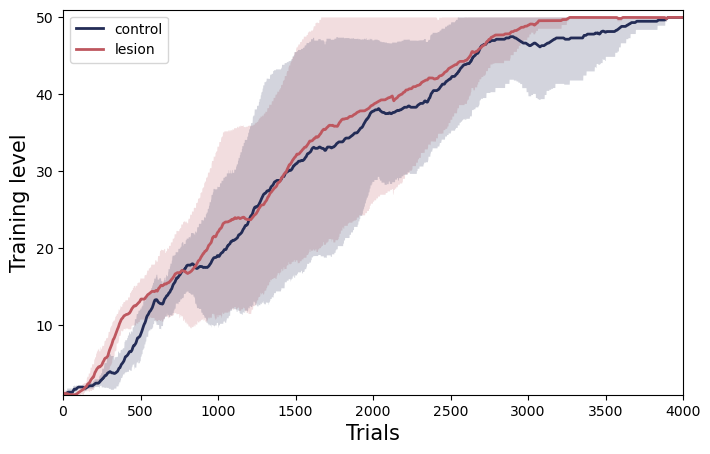

In [3]:
# Read CSV
pl_data = pd.read_csv(current_working_dir + 'hippocampus_learning_curves.csv')


# Extract data
categories = pl_data.catagory.values
animals = pl_data.animal.values
t_levels = parse_training_levels(pl_data.training_levels.values)

# Calculate mean and std for lesion and control groups
lesion_mask = categories == 'lesion'
lesion_MeanLearningCurve, lesion_std = calculate_mean_std(t_levels, lesion_mask)

control_mask = categories == 'control'
control_MeanLearningCurve, control_std = calculate_mean_std(t_levels, control_mask)

# Plot
%matplotlib inline
window = 10
xlim = 4000

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_xlim([0, xlim])
ax.set_ylim([1, 51])

ax.plot(convolve_movmean(control_MeanLearningCurve[:xlim], window), '-', color=dark_blue, linewidth=2,label = 'control')
ax.plot(convolve_movmean(lesion_MeanLearningCurve[:xlim], window), '-', color='#BE575F', linewidth=2, label = 'lesion')

ax.set_xlabel('Trials', fontsize=15)
ax.set_ylabel('Training level', fontsize=15)

fill_between_mean_std(ax, lesion_MeanLearningCurve, lesion_std, '#BE575F')
fill_between_mean_std(ax, control_MeanLearningCurve, control_std, dark_blue)

plt.legend(loc="upper left")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:52<00:00, 189.02it/s]


(0.0, 4000.0)

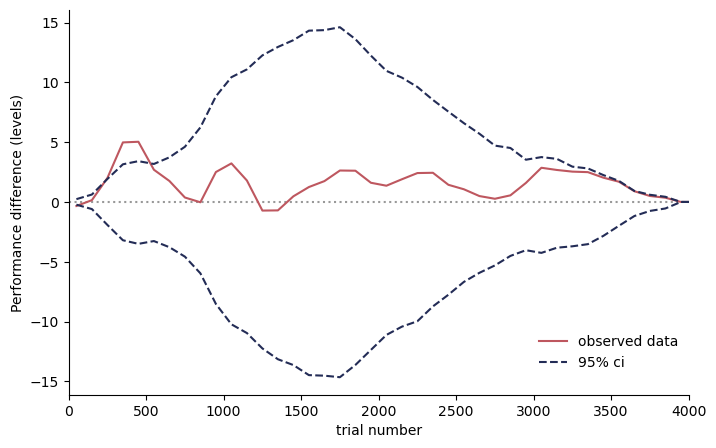

In [4]:
# Set cut-off for number of trials to consider
cut = 4000

# Initialize lists to store data
new, group, cum_trials, animalid = [], [], [], []

# Process each item in t_levels
for index, item in enumerate(t_levels):
    new += item[0:cut]  # Append the first 'cut' elements of the current item
    group += cut * [pl_data.catagory.values[index]]  # Assign group
    animalid += [animals[index]] * cut  # Append animal ID
    cum_trials += list(np.linspace(1, cut, cut))  # Generate cumulative trial numbers

# Create DataFrame with collected data
df = pd.DataFrame({'CumTrials': cum_trials, 'Level': new, 'Group': group, 'ID': animalid})

# Set seaborn color palette
color_palette = [(0.24715576, 0.49918708, 0.57655991), (160/255, 11/255 , 11/255)]
sns.set_palette(color_palette)


# Define function to generate experimental group labels
def generate_eg(list_size, prob, hue_order):
    return [hue_order[0] if random.random() < prob else hue_order[1] for _ in range(list_size)]



# define a 100-trial window to bin the data
XBIN = 100

# Bin trial indices
df["TrialIndexBinned"] = (df.CumTrials.values // XBIN) * XBIN + XBIN / 2

# Group by 'ID', 'Group', 'TrialIndexBinned' and calculate mean
df_bintr = df.groupby(['ID', 'Group', 'TrialIndexBinned']).mean().reset_index()
df_bintr['Performance'] = df_bintr.Level

hue_order = ['control', 'lesion']

# Calculate performance difference between groups
perdif_df = df_bintr[df_bintr.Group == hue_order[0]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance'] - \
            df_bintr[df_bintr.Group == hue_order[1]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance']

# Select necessary columns
df_colsel = df_bintr[['ID', 'Group', 'TrialIndexBinned', 'Performance']].copy()

# Calculate probability for experimental group
exp_gr = [df_colsel[df_colsel.ID == x].Group.unique()[0] for x in df_colsel.ID.unique()]
cb_prob = sum([x == hue_order[0] for x in exp_gr]) / len(exp_gr)

# Seed for reproducibility
np.random.seed(124321)

# Shuffle results
shuff_res = []

# Shuffle and compute performance differences
NSH = 10000
for _ in tqdm(range(NSH)):
    exp_grs = generate_eg(len(exp_gr), cb_prob,hue_order)
    egs_dict = dict(zip(df_colsel.ID.unique(), exp_grs))
    df_colsel['egs'] = df_colsel.ID.map(egs_dict)
    diff = df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance'] - \
           df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance']
    shuff_res.append(diff)

shrdf = pd.concat(shuff_res)

# Calculate real data performance difference
real_data = df_colsel[df_colsel.Group == hue_order[0]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance'] - \
            df_colsel[df_colsel.Group == hue_order[1]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance']
real_data *= -1

# Plot results
pos_ci = shrdf.groupby('TrialIndexBinned').quantile(.95)
neg_ci = shrdf.groupby('TrialIndexBinned').quantile(.05)

fig2 = plt.figure(figsize=(8, 5))
plt.axhline(0, ls='dotted', alpha=0.4, color='k')
plt.plot(real_data, color='#BE575F', label='observed data')
plt.plot(pos_ci, linestyle='--', color='#232C56', label='95% ci')
plt.plot(neg_ci, linestyle='--', color='#232C56')

x = pos_ci.reset_index().TrialIndexBinned
y1 = neg_ci.reset_index().Performance
y2 = real_data.reset_index().Performance

plt.fill_between(x, y1, y2, where=y2 <= y1, facecolor='#BE575F', alpha=.3, interpolate=True)
plt.ylabel('Performance difference (levels)')
plt.xlabel('trial number')
plt.legend(loc=(0.75, 0.05), frameon=False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim((0, 4000))

Figure 5c

C:\Users\Emmett\AppData\Local\Temp\ipykernel_18568\1772128185.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a, fontsize=18)
C:\Users\Emmett\AppData\Local\Temp\ipykernel_18568\1772128185.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(a, fontsize=18)


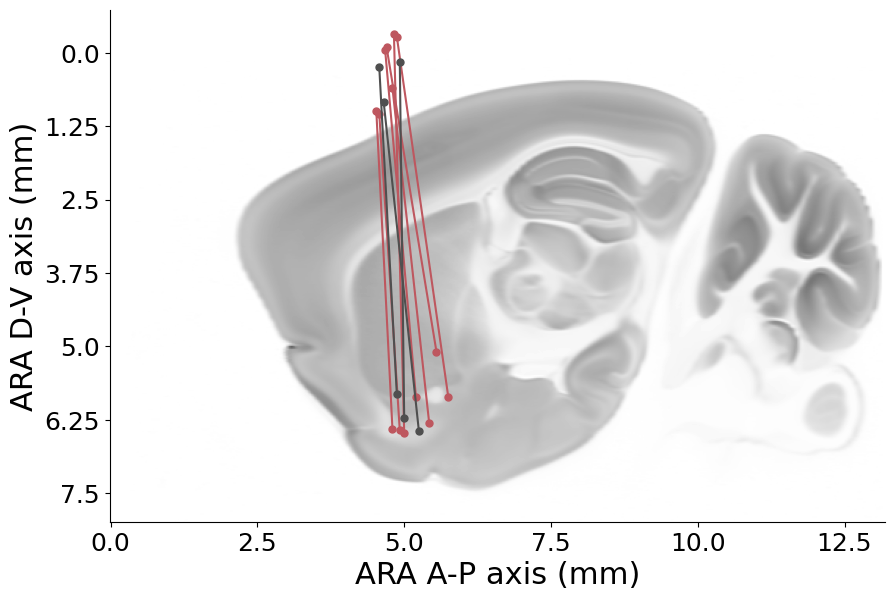

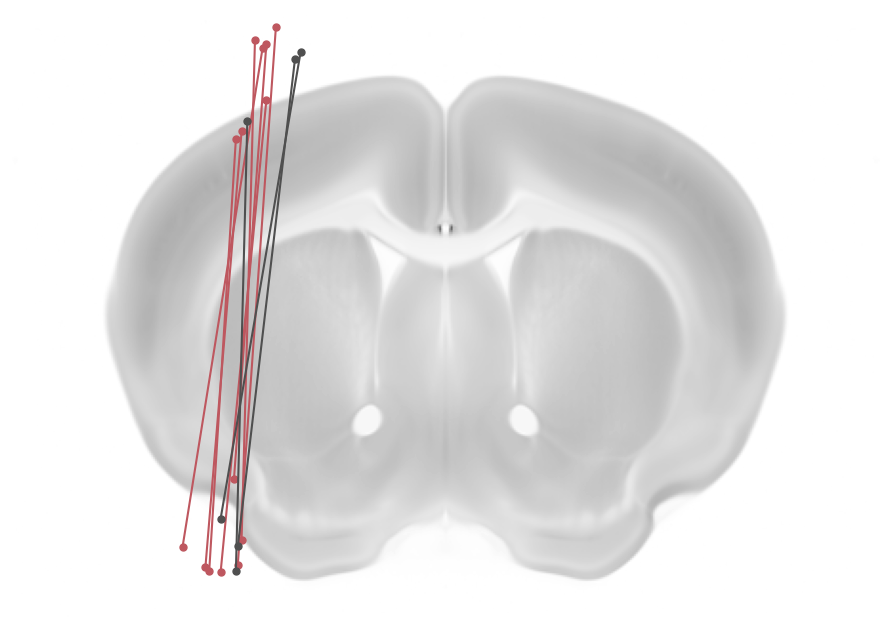

In [6]:
coords = pd.read_csv(current_working_dir+'probe_positions.txt', header=0)

# add the striatum limits
z_limits = [190, 200]
y_limits = [60, 271]
colours_ = ['buffer','#BE575F','#1A79B6','#4F4F4F','k']

# select number of slices to show, rows and cols
n_images = 1
rows = 1
cols = 1

fp = Path(current_working_dir+'probe_positions.txt')
parent = fp.parent

# read the file of points
X1 = coords.x1
Y1 = coords.y1
Z1 = coords.z1
X2 = coords.x2
Y2 = coords.y2
Z2 = coords.z2
Animal_Name = coords.Mouse_name

# select only the fibers used in the analysis
X1 = np.array(list(X1)).astype(float)
Y1 = np.array(list(Y1)).astype(float)
Z1 = np.array(list(Z1)).astype(float)
X2 = np.array(list(X2)).astype(float)
Y2 = np.array(list(Y2)).astype(float)
Z2 = np.array(list(Z2)).astype(float)
Animal_Name = np.array(list(Animal_Name))

# read atlas get slice numbers
atlas = Image.open(current_working_dir +'reference_25um_inverted.tif')
h,w = np.shape(atlas)
# decide on the number of images
step = int(np.floor((z_limits[1] - z_limits[0]) / n_images))
sl_list = list(range(z_limits[0], z_limits[1], step))
sl_list = sl_list[-n_images:]

# Mirror all to the right hemisphere
atlas_mid_point = w/2
for i in range(len(X1)):
    if X1[i] > atlas_mid_point:
        dist_to_center = atlas_mid_point - X1[i]
        X1[i] = atlas_mid_point + dist_to_center
for i in range(len(X2)):
    if X2[i] > atlas_mid_point:
        dist_to_center = atlas_mid_point - X2[i]
        X2[i] = atlas_mid_point + dist_to_center
        
for i in range(len(X1)):
    X1[i] = X1[i]-7
for i in range(len(Y2)):
    X2[i] = X2[i]-7

groups = list(coords.group.values)

# make the plot
fig, ax = plt.subplots(1, 1, figsize=[10,10])
# show striatum outline
str_im = Image.open(current_working_dir+'sagtial_reference_25um_inverted.tif')
ax.imshow(str_im, cmap='gray',alpha = 0.6)

for i in range(len(X1)):
    new_point = extend_line((Z1[i],Z2[i]),(Y1[i],Y2[i]),'positive')
    if groups[i] in [1,3]:
        ax.plot(new_point[0], new_point[-1], 'o-', color=colours_[groups[i]],
                alpha=1, markersize=5, markeredgewidth=1)

a=ax.get_xticks().tolist()
a= [25 * a[i] / 1000 for i in range(len(a))]
ax.set_xticklabels(a, fontsize=18)
a=ax.get_yticks().tolist()
a= [25 * a[i] / 1000 for i in range(len(a))]
ax.set_yticklabels(a, fontsize=18)
ax.set_xlabel('ARA A-P axis (mm)', fontsize=22)
ax.set_ylabel('ARA D-V axis (mm)', fontsize=22)

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.savefig(parent / 'sideview_plot.pdf',
            transparent=True, bbox_inches='tight')

# plot the fibers in the slices
fig2, axs = plt.subplots(rows, cols, figsize=[cols * w/50, rows * h/50])

for c,i in enumerate(sl_list):
    atlas.seek(i)
    axs.imshow(atlas, cmap='gray',alpha = 0.6)
    axs.axis('off')
# fig2.subplots_adjust(wspace=0, hspace=0)
fig2.tight_layout()

# plot the fibers
for c,x in enumerate(Z1):
    # find the index of the slice that this point is closest to
    templist = [np.abs(b - x) for b in sl_list]
    idx = np.argmin(templist)
    new_point = extend_line((X1[c],X2[c]),(Y1[c],Y2[c]),'positive')
    if groups[c] in [1,3]:
        axs.plot(new_point[0], new_point[-1], 'o-', color=colours_[groups[c]],
                alpha=1, markersize=5, markeredgewidth=1)

Figure 1D

In [7]:
#example

Figure 1E

In [8]:
#example

Figure 1F

C:\Users\Emmett\AppData\Local\Temp\ipykernel_18568\3930050558.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(data_dict["neuron_rel_forward_replay_positions"])[np.array(bool_) == 1]
C:\Users\Emmett\AppData\Local\Temp\ipykernel_18568\3930050558.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(data_dict["neuron_rel_awake_positions_forwards"])[np.array(bool_) == 1]
C:\Users\Emmett\AppData\Local\Temp\ipykernel_18568\3930050558.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a 

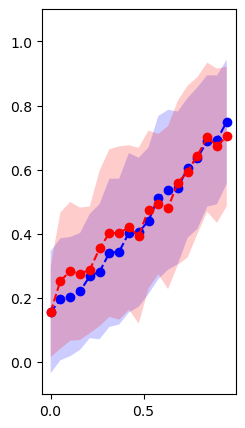

In [9]:


f4_working_dir = os.getcwd()
f4_working_dir = '//'.join(f4_working_dir.split('\\')[0:-2]) + r'//data/f4//'

with open(f4_working_dir+ 'spike_pos_awake_replay.json', 'r') as file:
    data_dict = json.load(file)

bool_ = data_dict["expert"]
# Example XY scatter data (replace this with your actual data)
x = np.array(data_dict["neuron_rel_forward_replay_positions"])[np.array(bool_) == 1]
x = [item for sublist in x for item in sublist]
y = np.array(data_dict["neuron_rel_awake_positions_forwards"])[np.array(bool_) == 1]
y = [item for sublist in y for item in sublist]

bool_ = data_dict["h_lesion"]
x2 = np.array(data_dict["neuron_rel_forward_replay_positions"])[np.array(bool_) == 1]
x2 = [item for sublist in x2 for item in sublist]
y2 = np.array(data_dict["neuron_rel_awake_positions_forwards"])[np.array(bool_) == 1]
y2 = [item for sublist in y2 for item in sublist]

# Plot
fig, ax = plt.subplots(1, 1,figsize=(2.5, 5))

xdat = [x,x2]
ydat = [y,y2]
num_bins = 20
bins_ = []
means_ = []
for i, col in enumerate(['blue','red']):
    means,sems,bins,binned_x = bin_position_data(xdat[i],ydat[i],num_bins)
    ax.plot(bins,means,'o--', c = col)
    upper = np.array(means) + np.array(sems)
    lower = np.array(means) - np.array(sems)
    ax.fill_between(sorted(bins),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=col,
        linewidth=1, linestyle='dashdot', antialiased=True)
    bins_+=[bins]
    means_+=[means]

    ax.set_ylim(-0.1,1.1)



Figure 1G

In [10]:
#example

Figure 1H

2
3
6
4
5
2
3
4
5


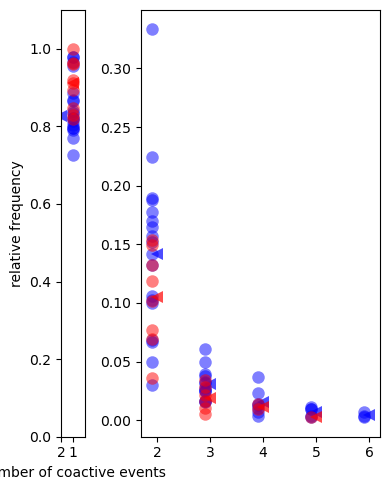

In [11]:
f4_working_dir = os.getcwd()
f4_working_dir = '//'.join(f4_working_dir.split('\\')[0:-2]) + r'//data/f4//'
file_path = f4_working_dir + 'all_recordings_replay_feature_data.json'

with open(file_path, 'r') as file:
    data = json.load(file)
    
e_coactive_freqs_counts = data['e_coactive_freqs_counts']

fig, [ax,ax2]= plt.subplots(1, 2,figsize=(4, 5),gridspec_kw={'width_ratios': [1, 10]})

plot_coactive_props(ax,ax2, data['e_coactive_freqs_counts'],'blue')
plot_coactive_props(ax,ax2, data['hl_coactive_freqs_counts'],'red')



In [12]:
##STATS

e_coactive_freqs_counts = data['e_coactive_freqs_counts']
hl_coactive_freqs_counts= data['hl_coactive_freqs_counts']
df = pd.DataFrame()
df['groups'] = ['control']*len(e_coactive_freqs_counts['1'])  + ['lesion']*len(hl_coactive_freqs_counts['1'])
for key in e_coactive_freqs_counts:
    current_var = e_coactive_freqs_counts[key]
    while len(current_var)<len(e_coactive_freqs_counts['1']):
        current_var +=[0] 
    try:
        hl_coactive_freqs_counts[key]
        current_var_l = hl_coactive_freqs_counts[key]
        while len(current_var_l)<len(hl_coactive_freqs_counts['1']):
            current_var_l +=[0]
    except:
        current_var_l = [0]*len(hl_coactive_freqs_counts['1'])   
    df[str(key)] = current_var + current_var_l
    
# Calculate the Euclidean distance matrix
values = df[['1', '2', '3', '4', '5', '6']].values
grouping = df['groups'].values

pairwise_distances = pdist(values, metric='euclidean')
distance_matrix = squareform(pairwise_distances)
dm = DistanceMatrix(distance_matrix)

# Perform PERMANOVA
results = permanova(dm, grouping, permutations=10000)
print(results)


method name               PERMANOVA
test statistic name        pseudo-F
sample size                      27
number of groups                  2
test statistic             3.310997
p-value                    0.063194
number of permutations        10000
Name: PERMANOVA results, dtype: object


Figure 1I

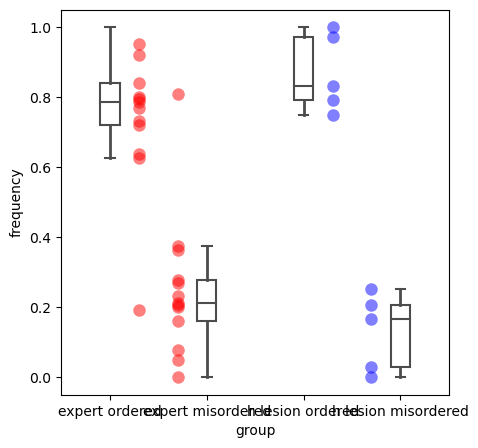

In [13]:
f4_working_dir = os.getcwd()
f4_working_dir = '//'.join(f4_working_dir.split('\\')[0:-2]) + r'//data/f4//'
file_path = f4_working_dir + 'all_recordings_replay_feature_data.json'

with open(file_path, 'r') as file:
    data = json.load(file)

ordered_misordered_bdown =[]
for item in data["mouse_summed_amounts"]:
    ordered_misordered_bdown += [list(np.array(item[0:4])/sum(item[0:4]))]
    
e_ordered = []
e_misordered = []
hl_ordered = []
hl_misordered = []
for index,item in enumerate(ordered_misordered_bdown):
    if len(item) > 0:
        if data["expert"][index] == 1:
            if index < 28: # ignore ones from other expert experiment (opto stim mice)
                e_ordered += [sum(item[0:3])]
                e_misordered += [item[-1]]    
        elif data["hlesion"][index] == 1:
            hl_ordered += [sum(item[0:3])]
            hl_misordered += [item[-1]]

fig, ax= plt.subplots(1, 1,figsize=(5, 5))

ax.plot(0.3*np.ones(len(e_ordered[0:-1])),e_ordered[0:-1], 'o', color = 'red', alpha = 0.5, markeredgewidth = 0, markersize = 9)
ax.plot(0.7*np.ones(len(e_misordered)),e_misordered, 'o', color = 'red', alpha = 0.5, markeredgewidth = 0, markersize = 9)
ax.plot(2.3*np.ones(len(hl_ordered)),hl_ordered, 'o', color = 'blue', alpha = 0.5, markeredgewidth = 0, markersize = 9)
ax.plot(2.7*np.ones(len(hl_misordered)),hl_misordered, 'o', color = 'blue', alpha = 0.5, markeredgewidth = 0, markersize = 9)


data = e_ordered+ e_misordered+hl_ordered+hl_misordered
groups = ['expert ordered'] * len(e_ordered) + ['expert misordered'] * len(e_misordered) + ['h lesion ordered'] * len(hl_ordered) + ['h lesion misordered'] * len(hl_misordered) 
plt_df = pd.DataFrame({'group':groups,'frequency': data })
ax=sns.boxplot( y = 'frequency', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

Observed Test Statistic: 0.7388082284935923
99 percentile: 0.5220480668756532
p-value: 0.00365


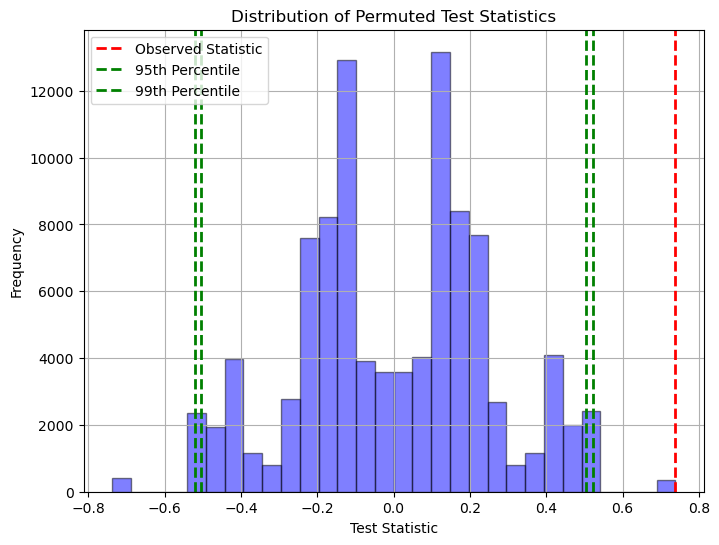

In [14]:
### STATS

list1 = hl_ordered
list2 = hl_misordered


# Define your test statistic function
def test_statistic(list1, list2):
    return np.mean(list1) - np.mean(list2)

# Compute the observed test statistic
observed_statistic = test_statistic(list1, list2)

# Combine the two lists
combined_data = list1 + list2

# Number of permutations
num_permutations = 100000

# Initialize an array to store the permuted test statistics
permuted_statistics = np.zeros(num_permutations)

# Permutation test
for i in range(num_permutations):
    # Shuffle the combined data
    np.random.shuffle(combined_data)
    
    # Split the shuffled data back into two lists
    permuted_list1 = combined_data[:len(list1)]
    permuted_list2 = combined_data[len(list1):]
    
    # Compute the test statistic for the permuted data
    permuted_statistics[i] = test_statistic(permuted_list1, permuted_list2)

# Calculate the p-value
p_value = np.mean(permuted_statistics >= observed_statistic)

print("Observed Test Statistic:", observed_statistic)
print("99 percentile:", np.percentile(permuted_statistics, 99))
print("p-value:", p_value)


plt.figure(figsize=(8, 6))
plt.hist(permuted_statistics, bins=30, alpha=0.5, color='blue', edgecolor='black')
plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label='Observed Statistic')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Distribution of Permuted Test Statistics')
plt.axvline(np.percentile(permuted_statistics, 97.5), color='green', linestyle='dashed', linewidth=2, label='95th Percentile')
plt.axvline(np.percentile(permuted_statistics, 2.5), color='green', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(permuted_statistics, 99), color='green', linestyle='dashed', linewidth=2, label='99th Percentile')
plt.axvline(np.percentile(permuted_statistics, 1), color='green', linestyle='dashed', linewidth=2)
plt.xlabel('Test Statistic')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
group1 = e_ordered + hl_ordered
group2 = e_misordered + hl_misordered
grouping = ['control'] * len(e_ordered) + ['lesion'] * len(hl_ordered)

stacked_list = [list(pair) for pair in zip(group1, group2)]

# data is stacked so that each row is a sample (animal) and each colum is a variable/test



pairwise_distances = pdist(stacked_list, metric='euclidean')
distance_matrix = squareform(pairwise_distances)
dm = DistanceMatrix(distance_matrix)

# Perform PERMANOVA
results = permanova(dm, grouping, permutations=999)
print(results)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      18
number of groups                  2
test statistic             1.494755
p-value                       0.251
number of permutations          999
Name: PERMANOVA results, dtype: object


Figure 1J

In [16]:
def find_closest_example(numbers, examples):
    # Initialize dictionaries to store the closest example and example totals
    closest_examples = {}
    example_totals = {example: 0 for example in examples}

    # Iterate over each number in the list
    for number in numbers:
        # Initialize a variable to keep track of the closest example
        closest_example = None
        min_distance = float('inf')  # Initialize the minimum distance to infinity

        # Compare the number with each example
        for example in examples:
            # Calculate the absolute difference between the number and example
            distance = abs(number - example)

            # Check if the current example is closer than the previous closest example
            if distance < min_distance:
                min_distance = distance
                closest_example = example

        # Update the closest example for the current number in the dictionary
        closest_examples[number] = closest_example

        # Increment the total count for the closest example
        example_totals[closest_example] += 1

    return closest_examples, example_totals

def relative_warp_values(e_f_warp_factors):
    rels = []
    for item in e_f_warp_factors:
        rels += [list(np.array(item)/sum(item))]
    return rels

def plot_warps(e_f_warp_factors,e_r_warp_factors,ax,var_str,bins_):

    bin_labels = [item + 'x' for item in np.array(bins_).astype(str)]

    means = []
    sems = []
    data_out_f = []
    for item in conactinate_nth_items(e_f_warp_factors):
        means += [np.mean(item)]
        sems += [np.std(item)]
        data_out_f += [item]
    ax.plot(means,'-->', color = 'red', markersize = 8, label = 'forward')
    upper = np.array(means)+ sems
    lower = np.array(means)- sems
    ax.fill_between((range(len(bin_labels))),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor='red',
        linewidth=1, linestyle='dashdot', antialiased=True)

    means = []
    sems = []
    data_out_r = []
    for item in conactinate_nth_items(e_r_warp_factors):
        means += [np.mean(item)]
        sems += [np.std(item)]
        data_out_r += [item]
    ax.plot(means,'--<', color = 'blue', markersize = 8,label = 'reverse')
    upper = np.array(means)+ sems
    lower = np.array(means)- sems
    ax.fill_between((range(len(bin_labels))),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor='blue',
        linewidth=1, linestyle='dashdot', antialiased=True)
    ax.set_title(var_str)
    
    # Set the vertical labels
    ax.set_xticks(range(len(bin_labels)))
    ax.set_xticklabels(bin_labels, rotation=90)
    
    ax.set_ylim(0,0.40)

    ax.legend()
    
    return(data_out_f,data_out_r)

255_1_1
255_1_2
255_1_4
256_1_1
262_1_1
262_1_2
262_1_4
262_1_5
262_1_6


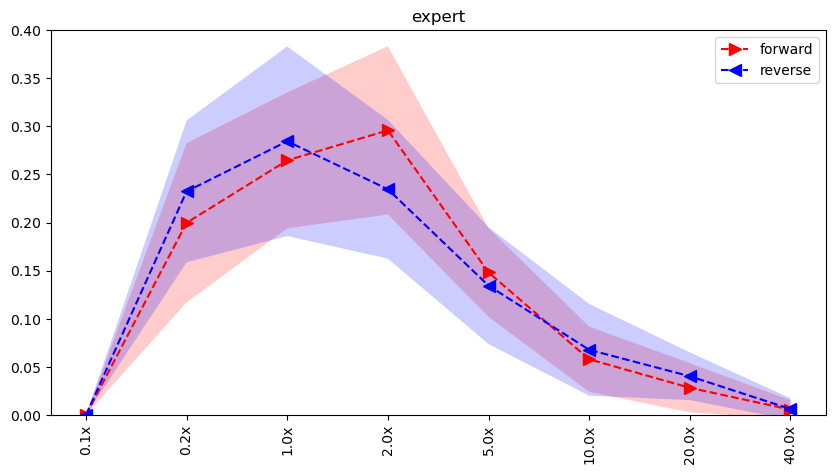

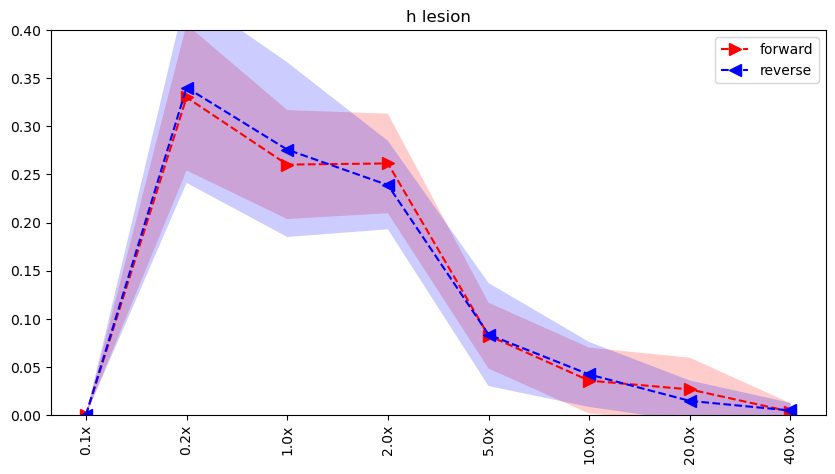

In [17]:
f4_working_dir = os.getcwd()
f4_working_dir = '//'.join(f4_working_dir.split('\\')[0:-2]) + r'//data/f4//'
regression_df = pd.read_csv(f4_working_dir + 'warps_df.csv')

sleep_time_point_df = pd.read_csv(f4_working_dir + 'sleep_time_points.csv')
expert_mice = sleep_time_point_df[sleep_time_point_df.group == 'expert'].mir.values
hlesion_mice = sleep_time_point_df[sleep_time_point_df.group == 'h_lesion'].mir.values

bins_ = [0.1, 0.2, 1,2, 5, 10,20,40]

e_f_warp_factors = []
e_r_warp_factors = []
hl_f_warp_factors = []
hl_r_warp_factors = []
l_f_warp_factors = []
l_r_warp_factors = []

e_forward = []
e_reverse = []
hl_forward = []
hl_reverse = []
l_forward = []
l_reverse = []

ef_data = []
er_data = []
hlf_data = []
hlr_data = []
lf_data = []
lr_data = []

for mouse, group in regression_df.groupby('mouse'):
    if mouse in expert_mice:

        #forward:
        data = list(group.warp_factor.values[group.warp_factor.values > 0])
        ef_data += data
        closest_examples,example_totals = find_closest_example(data,bins_)
        e_f_warp_factors +=[list(example_totals.values())]
        e_forward += [sum(example_totals.values())]
        #reverse:
        data = list(abs(group.warp_factor.values[group.warp_factor.values < 0]))
        er_data += data
        closest_examples,example_totals = find_closest_example(data,bins_)
        e_r_warp_factors +=[list(example_totals.values())]
        e_reverse += [sum(example_totals.values())]
    elif mouse in hlesion_mice:
        print(mouse)
        #forward:
        data = list(group.warp_factor.values[group.warp_factor.values > 0])
        hlf_data += data
        closest_examples,example_totals = find_closest_example(data,bins_)
        hl_f_warp_factors +=[list(example_totals.values())]
        hl_forward += [sum(example_totals.values())]
        #reverse:
        data = list(abs(group.warp_factor.values[group.warp_factor.values < 0]))
        hlr_data += data
        closest_examples,example_totals = find_closest_example(data,bins_)
        hl_r_warp_factors +=[list(example_totals.values())]
        hl_reverse += [sum(example_totals.values())]

        
e_f_warp_factors = relative_warp_values(e_f_warp_factors)
e_r_warp_factors = relative_warp_values(e_r_warp_factors)
hl_f_warp_factors = relative_warp_values(hl_f_warp_factors)
hl_r_warp_factors = relative_warp_values(hl_r_warp_factors)


    
fig,ax = plt.subplots(1, 1,figsize=(10, 5))
e_data_f,e_data_r = plot_warps(e_f_warp_factors,e_r_warp_factors,ax,'expert',bins_)
fig,ax1 = plt.subplots(1, 1,figsize=(10, 5))
hl_data_f,hl_data_r = plot_warps(hl_f_warp_factors,hl_r_warp_factors,ax1,'h lesion',bins_)


In [ ]:
##stats


Figure 1K

Figure 1L

Figure 1M

Figure 1N

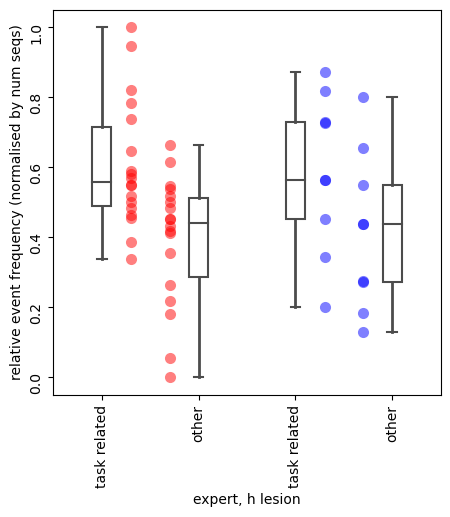

In [28]:
f4_working_dir = os.getcwd()
f4_working_dir = '//'.join(f4_working_dir.split('\\')[0:-2]) + r'//data/f4//'
file_path = f4_working_dir + 'all_recordings_replay_feature_data.json'

with open(file_path, 'r') as file:
    data = json.load(file)

# seq proportions (task seqs vs others) - mean across all
fig, ax= plt.subplots(1, 1,figsize=(5, 5))
e_rel_task_nontask = []
hl_rel_task_nontask = []
l_rel_task_nontask = []
for index,item in enumerate(data["rel_task_nontask"]):
    if data["expert"][index] == 1:
        e_rel_task_nontask += [item]
    elif data["hlesion"][index] == 1:
        hl_rel_task_nontask += [item]
    
for index,item in enumerate(e_rel_task_nontask):    
    ax.plot([0.3,0.7],item, 'o', color = 'red', alpha = 0.5, label='Data', markeredgewidth = 0, markersize = 8)
for index,item in enumerate(hl_rel_task_nontask):    
    ax.plot([2.3,2.7],item, 'o', color = 'blue', alpha = 0.5 , label='Data', markeredgewidth = 0, markersize = 8)
    
data = conactinate_nth_items(e_rel_task_nontask)[0] + conactinate_nth_items(e_rel_task_nontask)[1] + conactinate_nth_items(hl_rel_task_nontask)[0] + conactinate_nth_items(hl_rel_task_nontask)[1] 
groups = (['task related'] * len(conactinate_nth_items(e_rel_task_nontask)[0])) + (['other'] * len(conactinate_nth_items(e_rel_task_nontask)[1])) +  (['task related2'] * len(conactinate_nth_items(hl_rel_task_nontask)[0])) + (['other2'] * len(conactinate_nth_items(hl_rel_task_nontask)[1]))
plt_df = pd.DataFrame({'expert, h lesion':groups,'relative event frequency (normalised by num seqs)': data })
ax=sns.boxplot( y = 'relative event frequency (normalised by num seqs)', x = 'expert, h lesion', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

labels = ['task related', 'other', 'task related', 'other', ]
    
ax.set_xticks(range(0,len(labels)))
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=10, rotation =90)


Observed Test Statistic: 0.16970052500484822
p-value: 0.06277


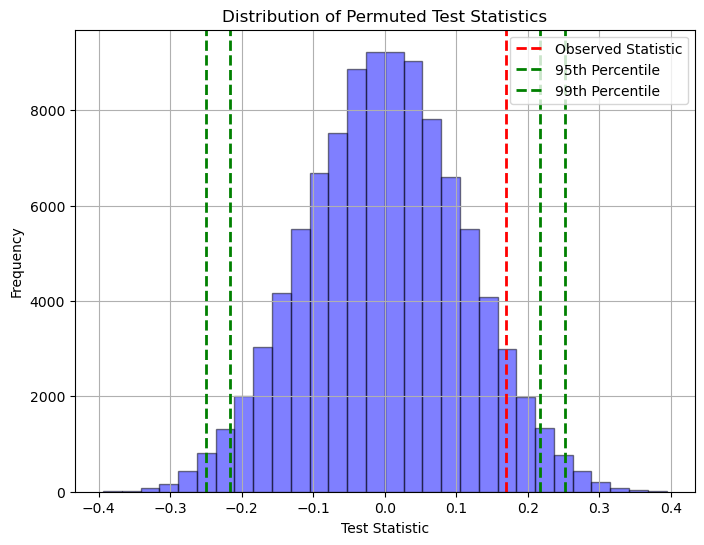

In [30]:
##stats h lesion task related vs other

list1= [item[0] for item in hl_rel_task_nontask]
list2= [item[1] for item in hl_rel_task_nontask]


# Define your test statistic function
def test_statistic(list1, list2):
    return np.mean(list1) - np.mean(list2)

# Compute the observed test statistic
observed_statistic = test_statistic(list1, list2)

# Combine the two lists
combined_data = list1 + list2

# Number of permutations
num_permutations = 100000

# Initialize an array to store the permuted test statistics
permuted_statistics = np.zeros(num_permutations)

# Permutation test
for i in range(num_permutations):
    # Shuffle the combined data
    np.random.shuffle(combined_data)
    
    # Split the shuffled data back into two lists
    permuted_list1 = combined_data[:len(list1)]
    permuted_list2 = combined_data[len(list1):]
    
    # Compute the test statistic for the permuted data
    permuted_statistics[i] = test_statistic(permuted_list1, permuted_list2)

# Calculate the p-value
p_value = np.mean(permuted_statistics >= observed_statistic)

print("Observed Test Statistic:", observed_statistic)
print("p-value:", p_value)


plt.figure(figsize=(8, 6))
plt.hist(permuted_statistics, bins=30, alpha=0.5, color='blue', edgecolor='black')
plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label='Observed Statistic')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Distribution of Permuted Test Statistics')
plt.axvline(np.percentile(permuted_statistics, 97.5), color='green', linestyle='dashed', linewidth=2, label='95th Percentile')
plt.axvline(np.percentile(permuted_statistics, 2.5), color='green', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(permuted_statistics, 99), color='green', linestyle='dashed', linewidth=2, label='99th Percentile')
plt.axvline(np.percentile(permuted_statistics, 1), color='green', linestyle='dashed', linewidth=2)
plt.xlabel('Test Statistic')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# stats, between groups 

stats.shapiro(conactinate_nth_items(e_rel_task_nontask)[1])
stats.shapiro(conactinate_nth_items(hl_rel_task_nontask)[0])

# all are normal, use manova 

from statsmodels.multivariate.manova import MANOVA
data = {
    'group': ['control']*len(conactinate_nth_items(e_rel_task_nontask)[0])+['lesion']*len(conactinate_nth_items(hl_rel_task_nontask)[0]),
    'TASK': conactinate_nth_items(e_rel_task_nontask)[0]+conactinate_nth_items(hl_rel_task_nontask)[0],
    'NONTASK': conactinate_nth_items(e_rel_task_nontask)[1]+conactinate_nth_items(hl_rel_task_nontask)[1],
}
df = pd.DataFrame(data)

# Perform MANOVA
manova = MANOVA.from_formula('TASK + NONTASK ~ group', data=df)
print(manova.mv_test())


                                 Multivariate linear model
                                                                                            
--------------------------------------------------------------------------------------------
       Intercept                Value          Num DF  Den DF         F Value         Pr > F
--------------------------------------------------------------------------------------------
          Wilks' lambda                -0.0000 2.0000 24.0000 -54043195528445968.0000 1.0000
         Pillai's trace                 1.0000 2.0000 24.0000 -54043195528445968.0000 1.0000
 Hotelling-Lawley trace -4503599627370497.0000 2.0000 24.0000 -54043195528445960.0000 1.0000
    Roy's greatest root -4503599627370497.0000 2.0000 24.0000 -54043195528445968.0000 1.0000
--------------------------------------------------------------------------------------------
                                                                                            
-----------